In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
import seaborn as sns
from enum import Enum
import matplotlib.colors as mcolors
import colorsys

### Make combined File

In [92]:
sdqlpy_results =  pd.read_csv("../test_results/hyper_sdqlpy_pandas_tpch_opt_all_comparison_test_results.csv") 
sdqlpy_results = sdqlpy_results[sdqlpy_results["Data Type"].isin(["SDQLpy", "Pandas"])]

sdqlpy_results['Query Name'] = sdqlpy_results['Query Name'].replace(
    {
        'Pandas Converted (Hyper DB)': 'Pandas NoOrder'
     }
)

In [93]:
pg_results =  pd.read_csv("../test_results/pg_duck_hyper_tpch_test_results.csv")
pg_results = pg_results[pg_results["Query Name"] == "Pandas Converted (Postgres)"]

In [94]:
results = pd.read_csv("../test_results/pg_duck_hyper_tpch_modif_test_results.csv") 

results = pd.concat([results, sdqlpy_results, pg_results], ignore_index=True)
results.to_csv("../test_results/pg_duck_hyper_tpch_combined_test_results.csv", index=False)
# results = results.rename(columns={"Average": "Mean"})

## Make Graphs

- Area dimensions: 84.1 wide (inches), 29 high

In [95]:
box_height = 29
box_width = 84.1 / 3

In [96]:
results = pd.read_csv("../test_results/pg_duck_hyper_tpch_combined_test_results.csv") 

In [97]:
print(f"Overall Results: {len(results)}")

# Filter for Correct == True and Executed == Yes
results = results[(results.Correct == True) & (results.Executed == "Yes")]
print(f"Correct Results: {len(results)}")

Overall Results: 264
Correct Results: 264


In [98]:
def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())

def pre_process(df):
    # Sort Query Name column to in-order
    def extract_number(name):
        return int(name.split(" ")[1])

    df['Query Number'] = df.apply(lambda row : extract_number(row['Query Number']), axis = 1)
    df = df.sort_values(['Query Number'])

    # Fix the runs column
    def fix_runs(runs):
        new_runs = list(str(str(runs)[1:-1]).split(","))
        for i in range(0, len(new_runs)):
            new_runs[i] = float(new_runs[i].strip())
        return new_runs

    df['Runs'] = df.apply(lambda row : fix_runs(row['Runs']), axis = 1)

    def ignore_first_gmean(runs):
        return g_mean(runs[1:])
    
    def ignore_first_mean(runs):
        return sum(runs[1:]) / len(runs[1:])

    df["Mean"] = df.apply(lambda row : ignore_first_mean(row['Runs']), axis = 1)
    df["Query Type"] = df["Query Name"]
    df = df[["Query Type", "Query Number", "Mean", "Runs"]]
    
    return df

results = pre_process(results)

In [99]:
all_named_colors = {}
all_named_colors.update(mcolors.TABLEAU_COLORS)

def handle_colour(color):
    if "tab:" in color:
        return all_named_colors[color]
    else:
        raise Exception(f"Unrecognised color format: {color}")

def scale_lightness(hex, scale_l):
    # convert rgb to hls
    rgb = mcolors.ColorConverter.to_rgb(hex)
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

In [100]:
def make_average_graph(df, order, color, hatching, filename, x_value='Query Number', y_value='Mean'):
    assert len(order) == len(color) == len(hatching), f"Order: {len(order)} rows, Colour: {len(color)} rows and Hatching: {len(hatching)} rows"
    print(f"The DataFrame has {len(df)} rows")
    
    # plot with seaborn barplot
    sns.set(rc={'figure.figsize':(box_height, box_width)})
    # Set DPI if resolution looks bad
    # sns.set(rc={'figure.dpi': 300})
    background_color = '#f1f4f5'
    sns.set(rc={'axes.facecolor':background_color})
    plt.rcParams['patch.linewidth'] = 1.0
    plt.rcParams['patch.edgecolor'] = 'k'
    
    plt.rc('axes', labelsize=36)    # fontsize of the x and y labels
    # plt.rc('xtick', labelsize=36) 

    ax = sns.barplot(data=df, x=x_value, y=y_value, hue='Query Type',
                     palette=color, hue_order=order)
    
    # Loop over the bars
    for bars, hatch in zip(ax.containers, hatching):
        if hatch != None:
            for bar in bars:
                bar.set_hatch(hatch)
    
    ax.set_yscale("log", base=10)
    ax.set(xlabel='', ylabel='Mean Runtime (ms)')  # , 

    # the non-logarithmic labels 
    ticks = [1, 10, 100, 1000, 10000]
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)
    
    #set parameters for tick labels
    plt.tick_params(axis='x', which='major')
    plt.tick_params(axis='y', which='major', direction="out", colors="k", left=True, labelsize=24)
    
    plt.xticks(rotation=45, ha='right')
    
    # Hide x-axis tick labels
    plt.xticks([])
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    
    # leg_artists = []
    # for i in range(len(order)):
    #     p = matplotlib.patches.Patch(facecolor=color[i], hatch=hatching[i])
    #     # can also explicitly declare 2nd color like this
    #     #p = matplotlib.patches.Patch(facecolor='#DCDCDC', hatch=hatch_dict[i], edgecolor='0.5')

    #     leg_artists.append(p)

    # # Add them to legend
    # ax.legend(leg_artists, order, loc='upper center', bbox_to_anchor=(0.5, 1.10),
    #           ncol=4, fancybox=True, shadow=True)

    if filename != None:
        import os  
        os.makedirs(os.path.dirname(filename), exist_ok=True)  
        plt.savefig(filename, bbox_inches="tight")
    plt.show()

## Statistics

In [101]:
overall = results.groupby("Query Type").agg(
    overall_mean_runtime=("Mean", g_mean)
)
overall = overall.sort_values(by="overall_mean_runtime")
overall = overall.rename(columns={"overall_mean_runtime": "Overall Mean Runtime (s)"})

overall.head(10)

,Overall Mean Runtime (s)
Query Type,
"O1,O2,O3,O4 SDQLpy",0.170093
"O1,O2,O3 SDQLpy",0.189468
"O1,O2 SDQLpy",0.202112
O1 SDQLpy,0.205774
Hyper DB,0.275704
Duck DB,0.323686
Naive SDQLpy,0.369673
Pandas Converted (Hyper DB),0.426110
Pandas NoOrder,0.524752


### Pandas Graph

In [102]:
log_graph = overall.reset_index()

# 'Pandas Converted (Postgres)',
# 'Pandas Converted (Duck DB)', 

all_6_order = ["Postgres", 'Duck DB', "Hyper DB",  "Pandas Converted (Hyper DB)"]
all_6_data = log_graph[log_graph["Query Type"].isin(all_6_order)]

all_6_data = all_6_data.set_index('Query Type').loc[all_6_order]
all_6_data = all_6_data.reset_index()

all_6_data = all_6_data.rename(columns={"Overall Mean Runtime (s)" : "Mean"})
all_6_data['Mean'] = all_6_data['Mean'].apply(lambda x : x * 1000)

The DataFrame has 4 rows


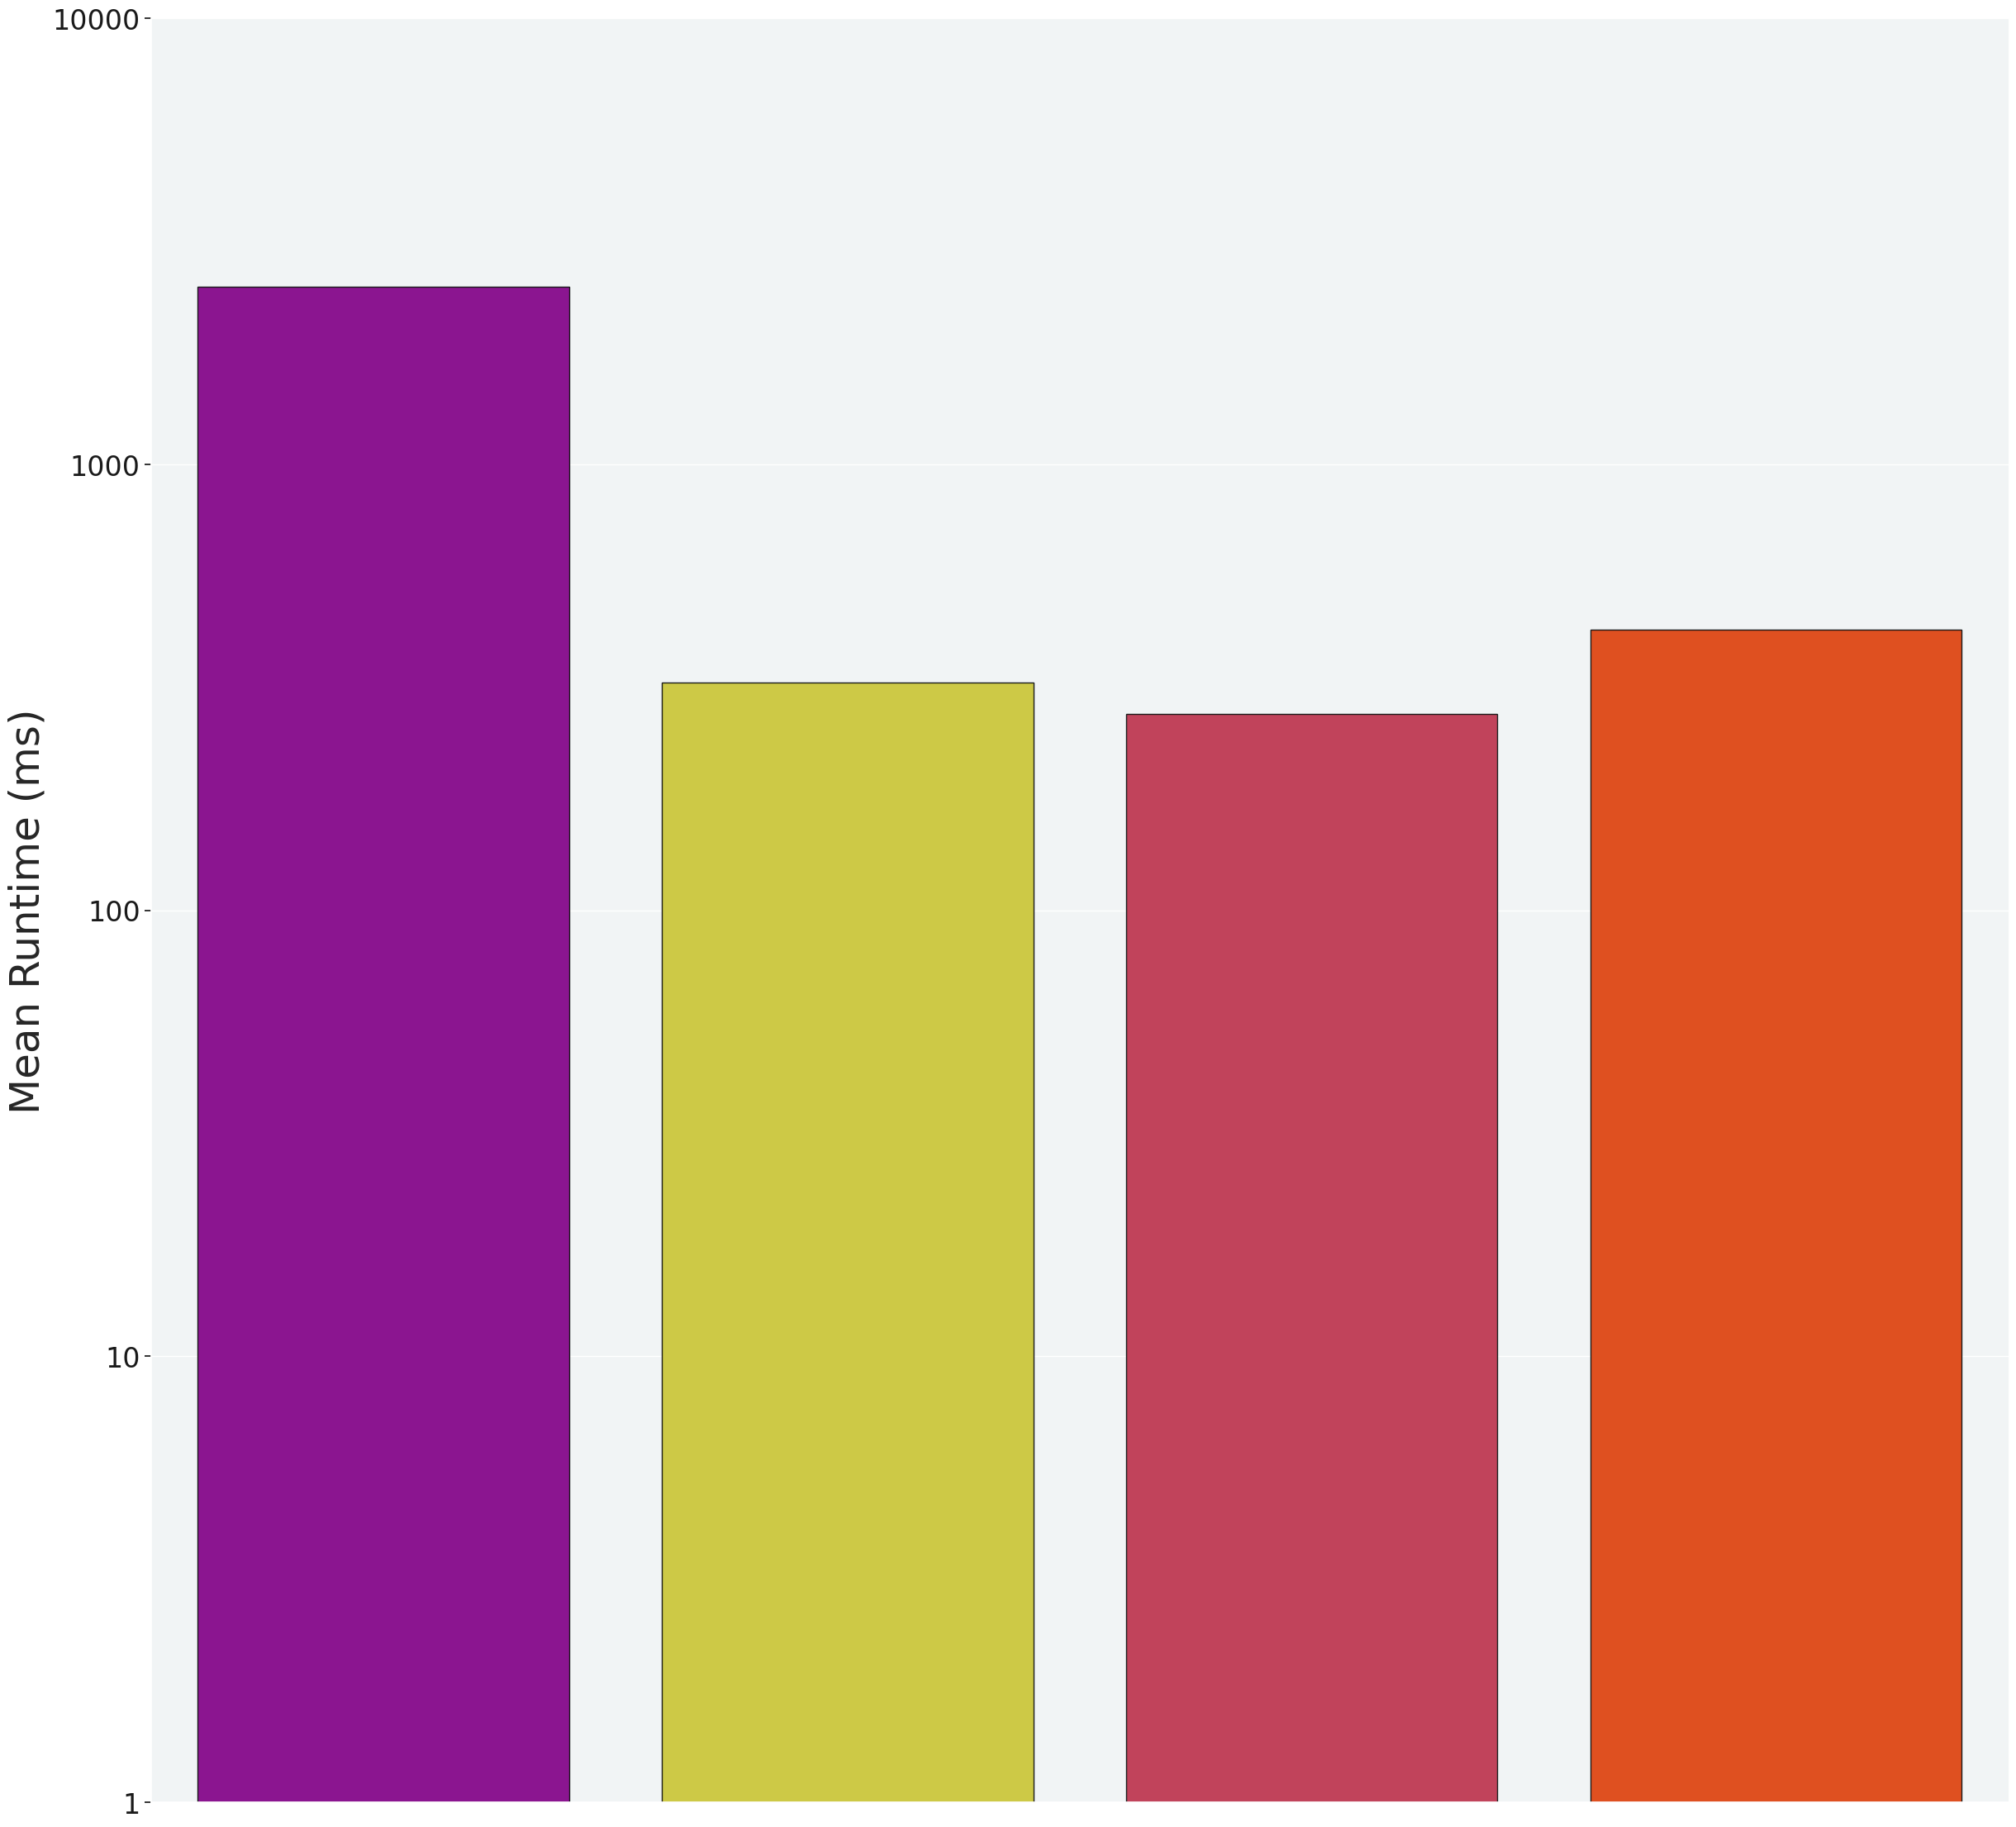

In [103]:
# PostgreSQL, Duck DB, HyperDB, Pandas (Hyper)
all_6_color = ["#9E00A4", "#E4DE2F", "#d62e4e", "#ff4000"]
all_6_hatch = [None, None, None, None]
all_6_filename = "../analysis_results/cgo/pandas_graphs"

make_average_graph(all_6_data,
                   all_6_order,
                   all_6_color,
                   all_6_hatch,
                   all_6_filename,
                   "Query Type")

### Database Compare Graph

In [104]:
log_graph = overall.reset_index()

db_comp_order = ['Pandas Converted (Postgres)', 'Pandas Converted (Duck DB)', "Pandas Converted (Hyper DB)"]
db_comp_data = log_graph[log_graph["Query Type"].isin(db_comp_order)]

db_comp_data = db_comp_data.set_index('Query Type').loc[db_comp_order]
db_comp_data = db_comp_data.reset_index()

db_comp_data = db_comp_data.rename(columns={"Overall Mean Runtime (s)" : "Mean"})
db_comp_data['Mean'] = db_comp_data['Mean'].apply(lambda x : x * 1000)

The DataFrame has 3 rows


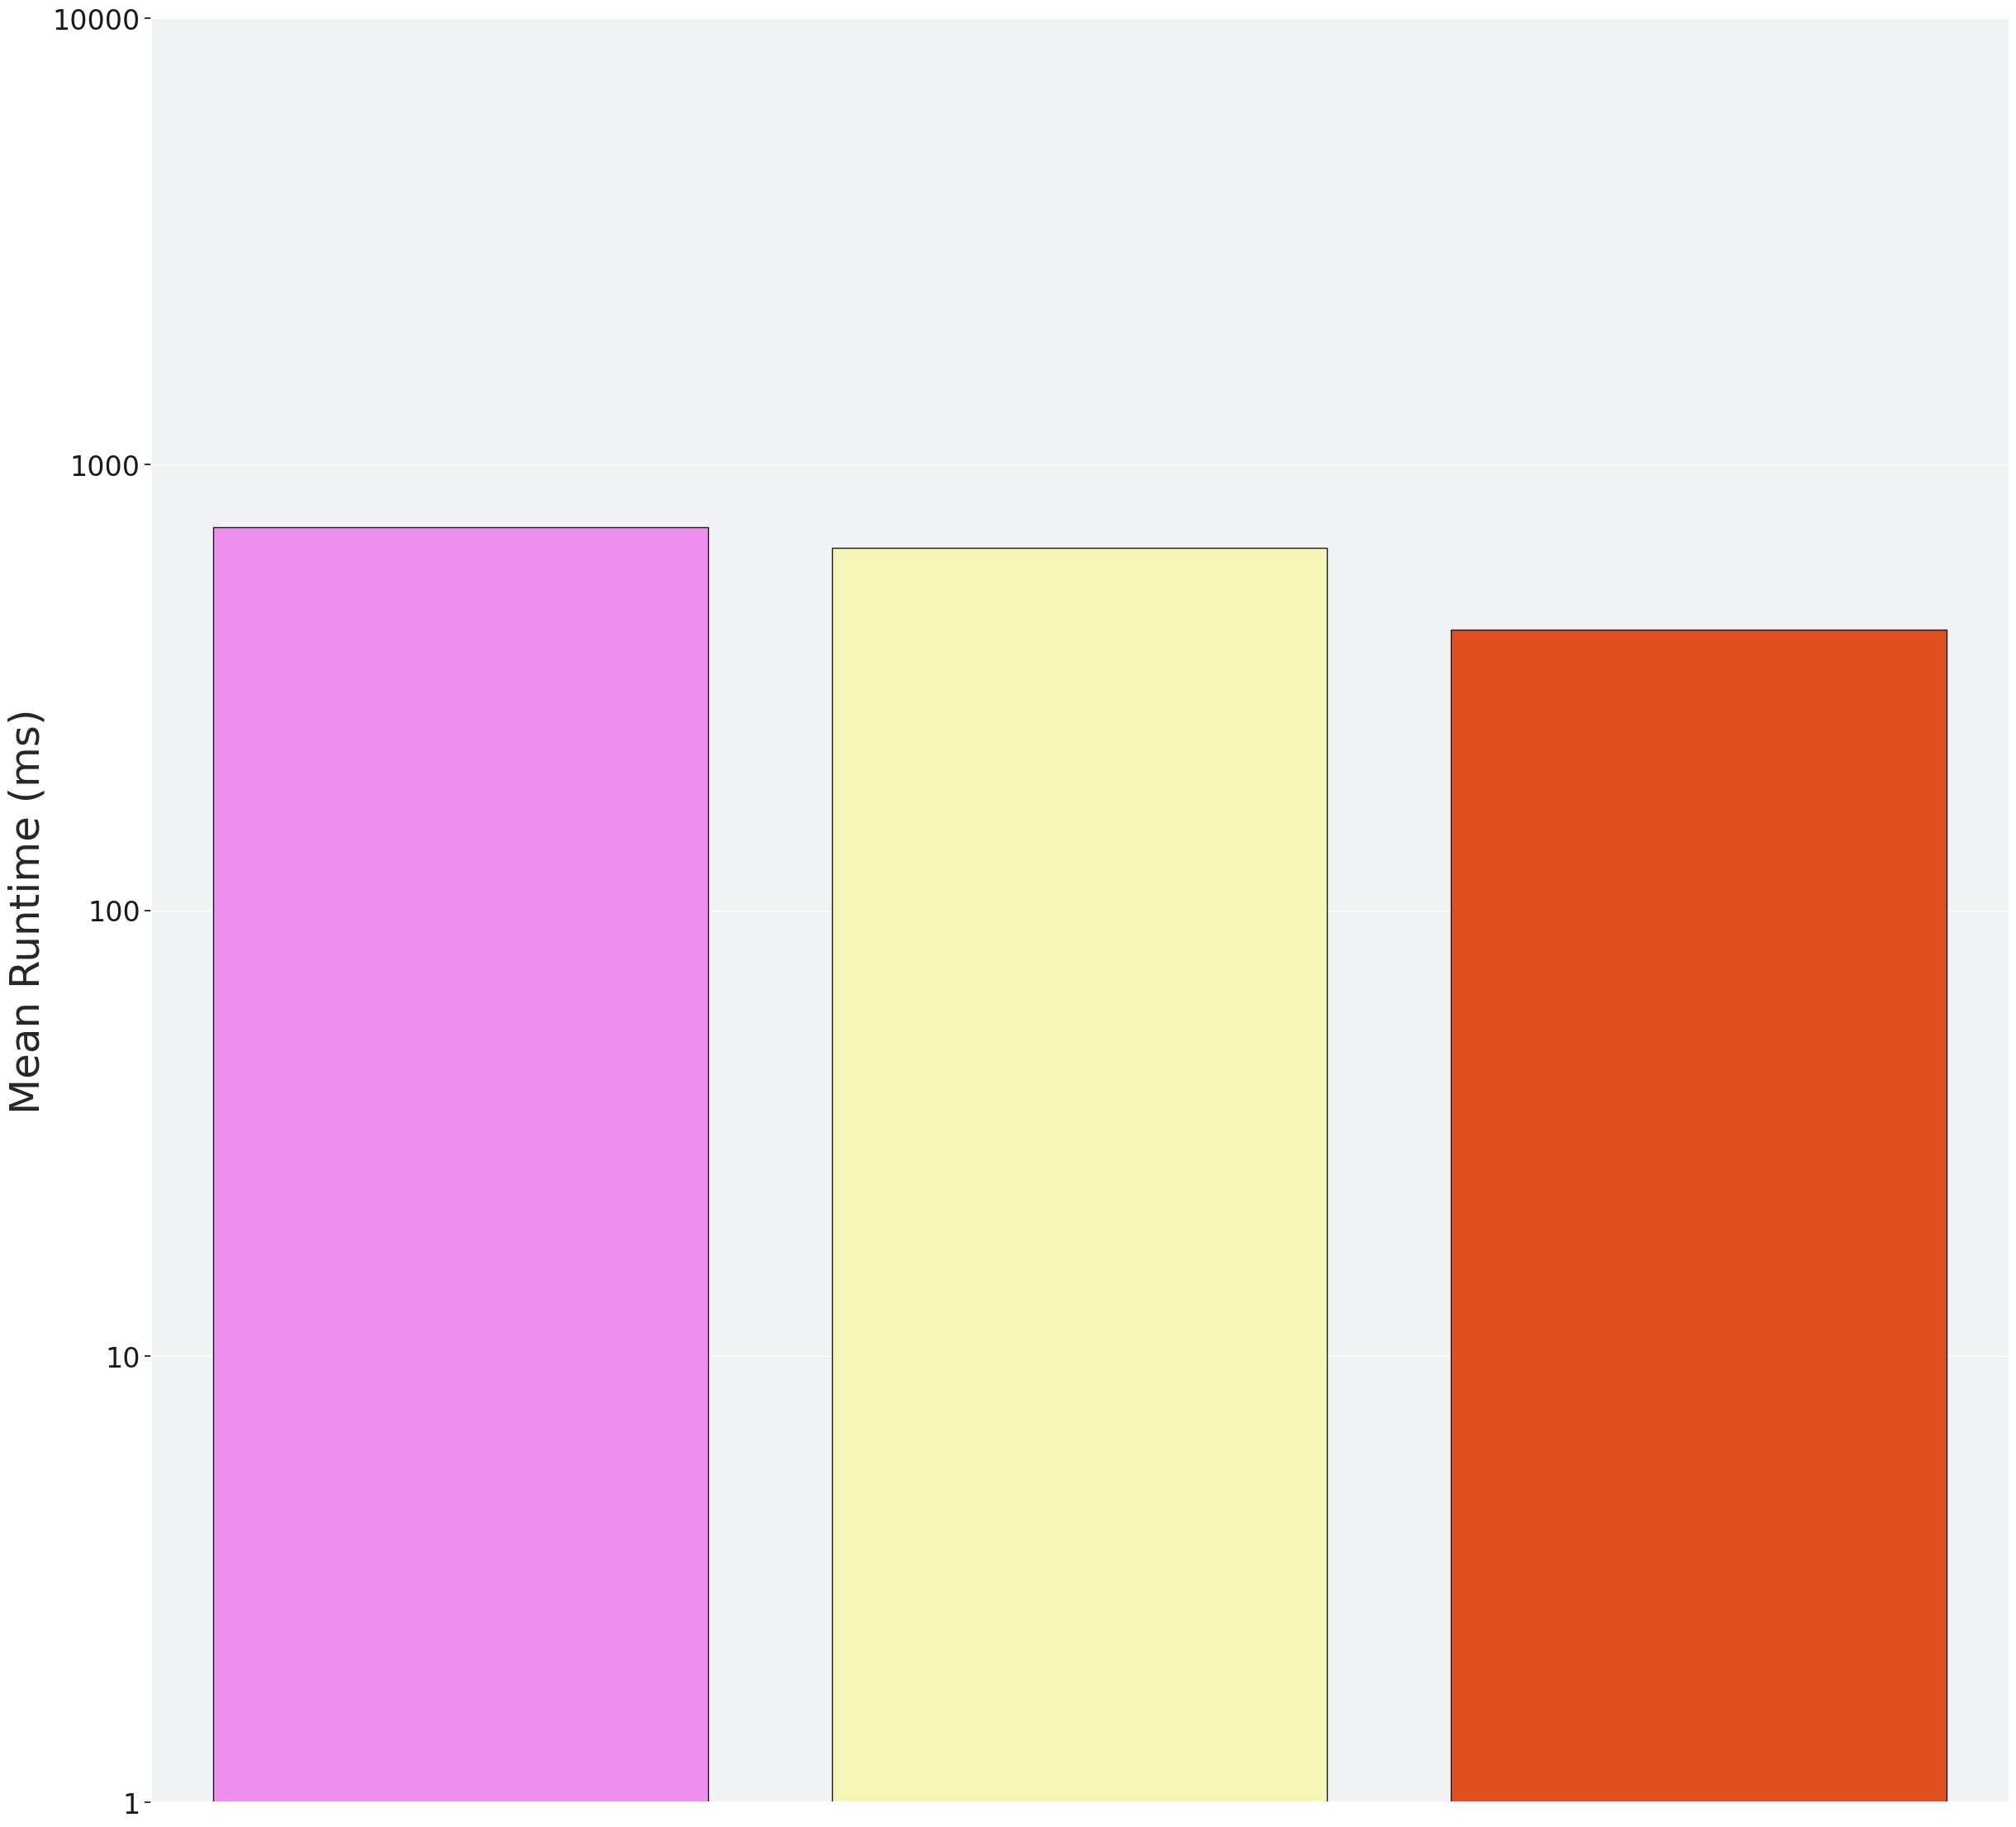

In [105]:
# Pandas (PostgreSQL), Pandas (Duck DB), HyperDB, Pandas (Hyper)
db_comp_color = ["#FF7FFF", "#FFFFAE", "#ff4000"]
db_comp_hatch = [None, None, None]
db_comp_filename = "../analysis_results/cgo/database_graphs"

make_average_graph(db_comp_data,
                   db_comp_order,
                   db_comp_color,
                   db_comp_hatch,
                   db_comp_filename,
                   "Query Type")

### SDQLpy Compare Graph

In [106]:
log_graph = overall.reset_index()

log_graph['Query Type'] = log_graph['Query Type'].replace(
    {
        'Pandas NoOrder': 'Pandas',
        'O1,O2 SDQLpy': 'O1-O2 SDQLpy',
        'O1,O2,O3 SDQLpy': 'O1-O3 SDQLpy',
        'O1,O2,O3,O4 SDQLpy': 'O1-O4 SDQLpy',
     }
)

sdqlpy_comp_order = ['Pandas', 'Naive SDQLpy', 'O1 SDQLpy', 'O1-O2 SDQLpy', 'O1-O3 SDQLpy', 'O1-O4 SDQLpy', 'Hyper DB']
sdqlpy_comp_data = log_graph[log_graph["Query Type"].isin(sdqlpy_comp_order)]

sdqlpy_comp_data = sdqlpy_comp_data.set_index('Query Type').loc[sdqlpy_comp_order]
sdqlpy_comp_data = sdqlpy_comp_data.reset_index()

sdqlpy_comp_data = sdqlpy_comp_data.rename(columns={"Overall Mean Runtime (s)" : "Mean"})
sdqlpy_comp_data['Mean'] = sdqlpy_comp_data['Mean'].apply(lambda x : x * 1000)

The DataFrame has 7 rows


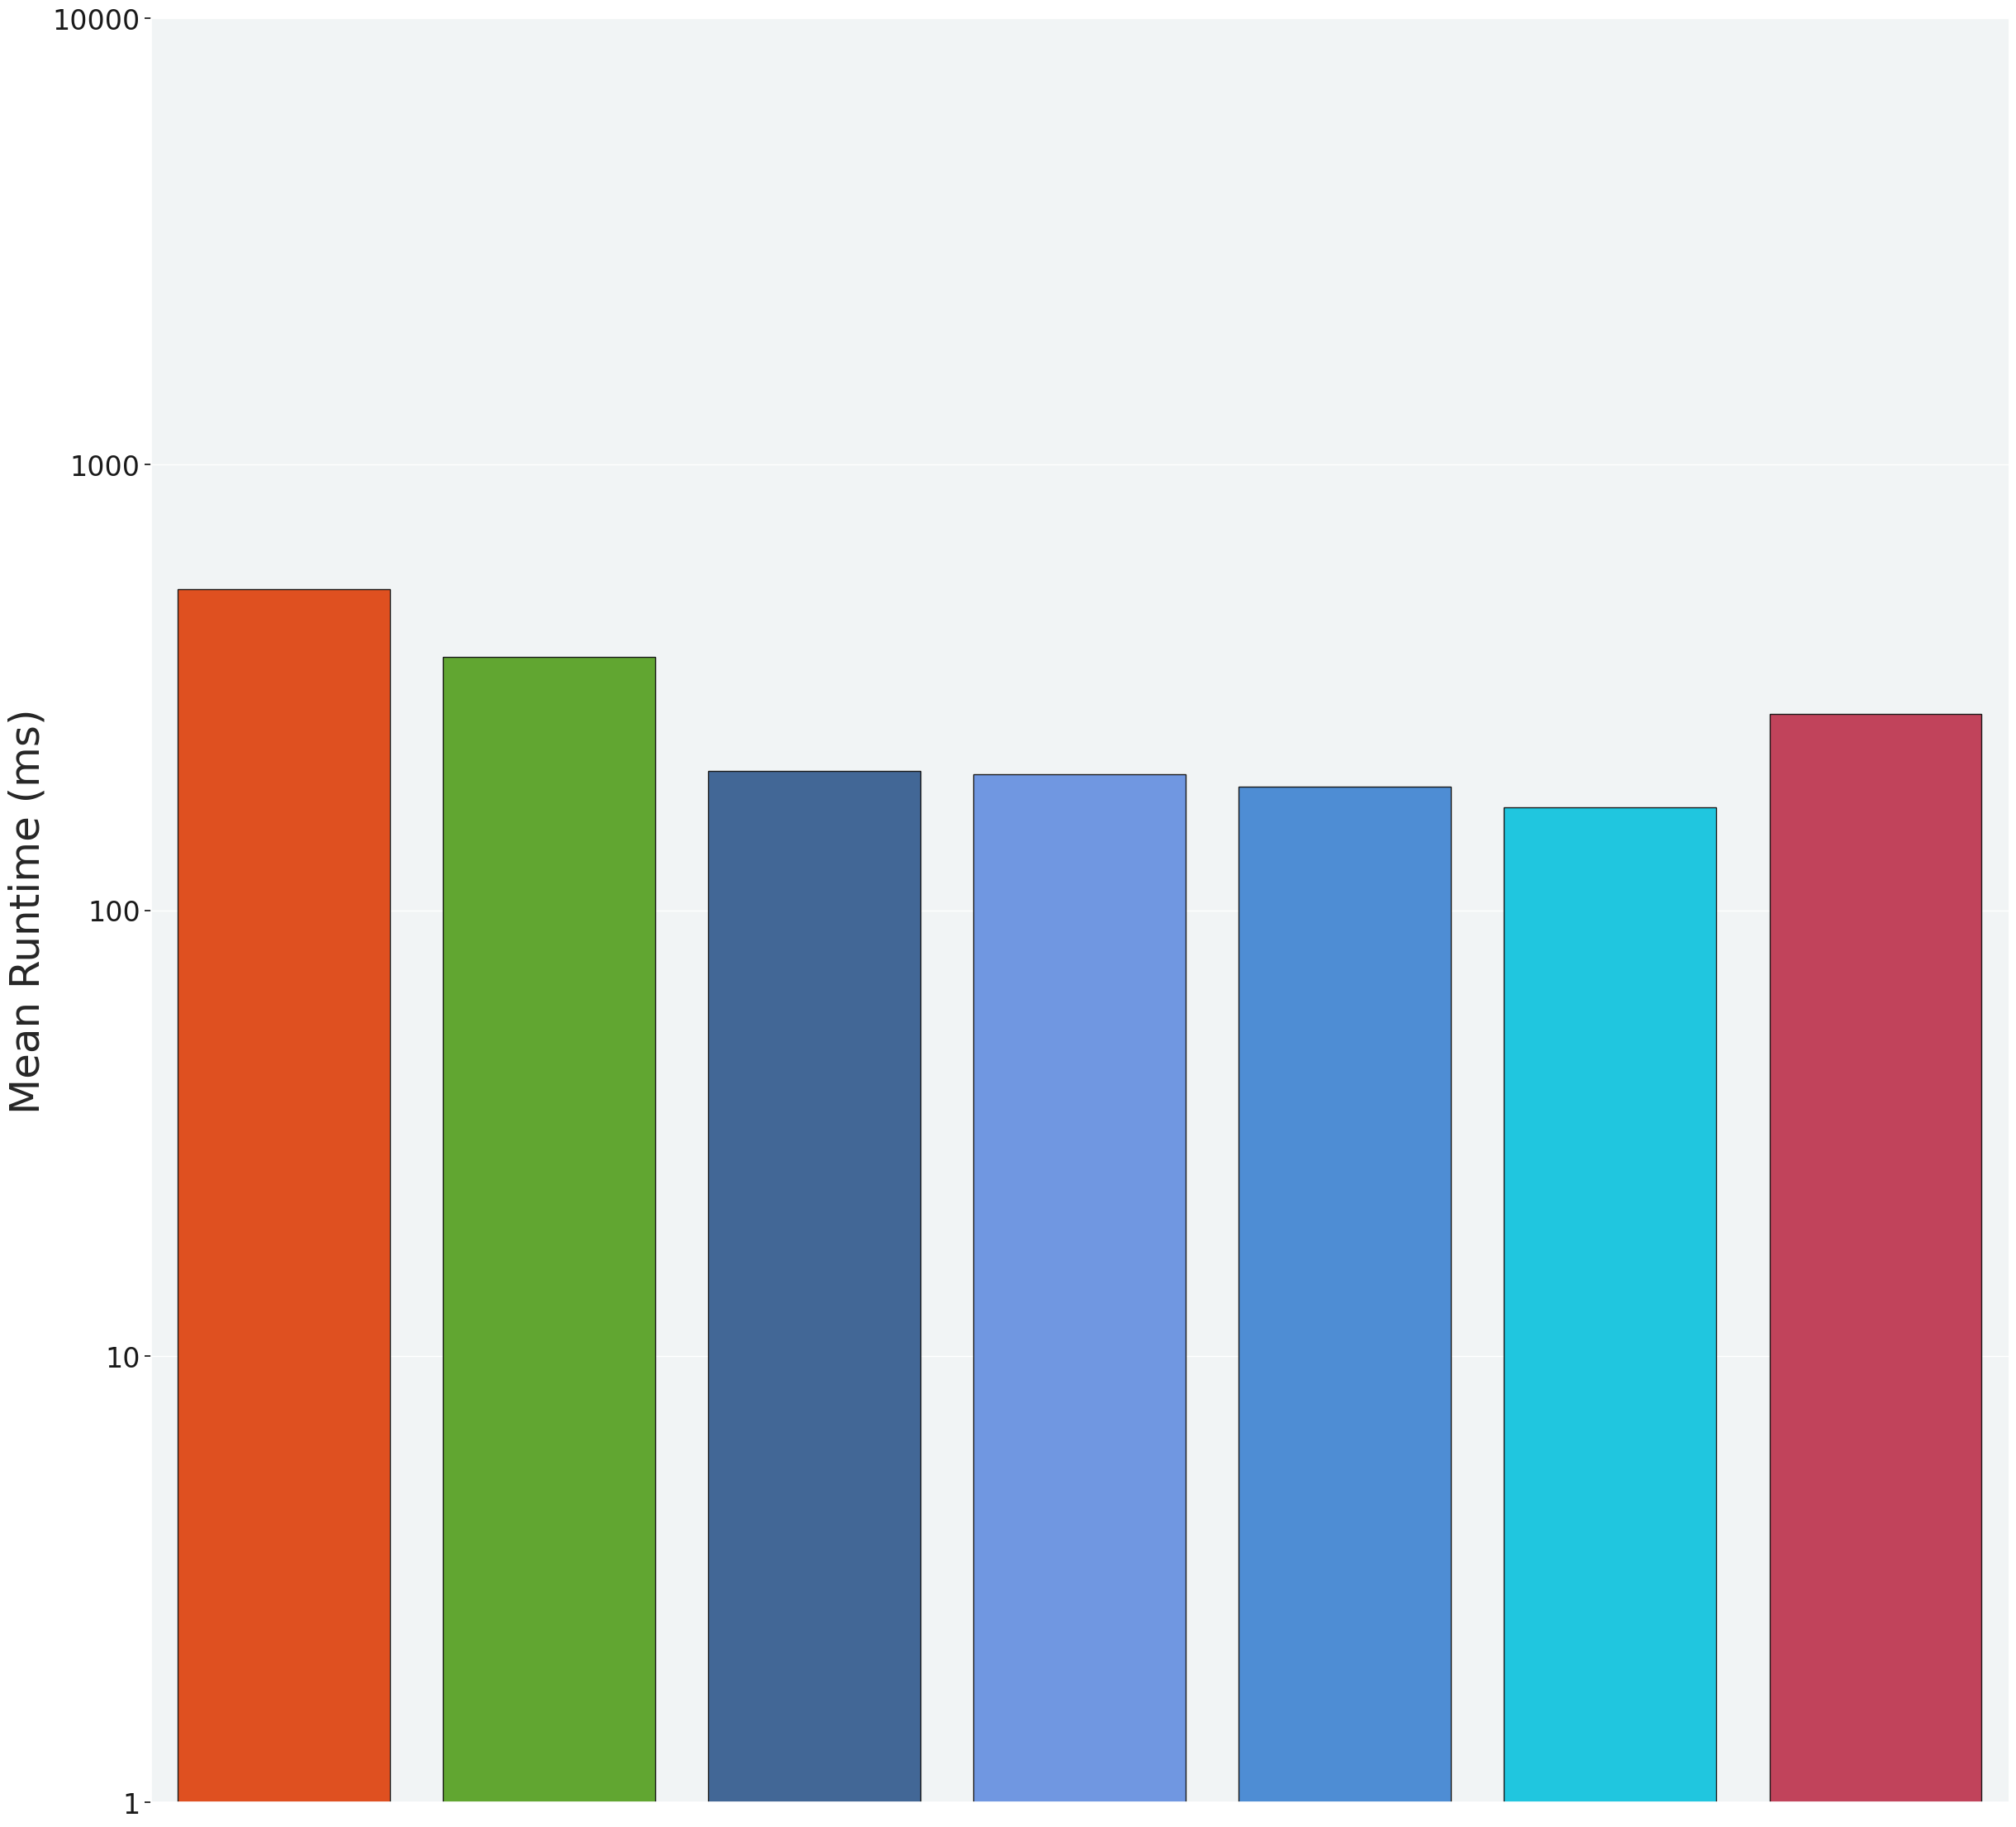

In [107]:
# PANDAS (Hyper), Naive SDQLpy, O1, O1-O2, O1-O3, O1-O4, HyperDB
sdqlpy_comp_color = ['#ff4000', '#5eb91e', '#3465a4', '#5d91f4', '#378ceb', '#00deff', '#d62e4e']
sdqlpy_comp_hatch = [None, None, None, None, None, None, None]
sdqlpy_comp_filename = "../analysis_results/cgo/sdqlpy_graphs"

make_average_graph(sdqlpy_comp_data,
                   sdqlpy_comp_order,
                   sdqlpy_comp_color,
                   sdqlpy_comp_hatch,
                   sdqlpy_comp_filename,
                   "Query Type")